In [ ]:
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from pathlib import Path
from sklearn.neighbors import KernelDensity
from matplotlib import colors
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# make sure Traffy_0104_English.csv is stored under traffy_data in this folder

In [16]:
def load_csv(file_name):
    # Get the path to the current directory
    current_dir = Path.cwd()
    
    # Define the relative path to the CSV file from the current directory
    csv_data = os.path.join(current_dir, "traffy_data")
    csv_path = os.path.join(csv_data, file_name)

    # Load the CSV file
    df = pd.read_csv(csv_path, delimiter=',')
    
    return df

In [33]:
def save_shapefile(gdf, file_name):
    # Get the current working directory (where the notebook is located)
    current_dir = Path.cwd()
    
    # Define the relative path to the directory where you want to save the shapefile
    save_dir = os.path.join(current_dir, "processed_traffy")
    
    # Ensure the save directory exists, create it if it doesn't
    os.makedirs(save_dir, exist_ok=True)
    
    # Define the full path to save the shapefile
    shapefile_path = os.path.join(save_dir, file_name)
    
    # Save the GeoDataFrame to a shapefile
    gdf.to_file(shapefile_path)


def load_shapefile(file_name):
    # Get the current working directory (where the notebook is located)
    current_dir = Path.cwd()
    
    # Define the relative path to the directory where the shapefile is saved
    shapefile_dir = os.path.join(current_dir, "processed_traffy")
    
    # Define the full path to the shapefile
    shapefile_path = os.path.join(shapefile_dir, file_name)
    
    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    return gdf

In [17]:
df = load_csv('Traffy_0104_English.csv')
df = df.drop_duplicates(subset='comment', keep='first')
# Set the threshold for non-NaN values
threshold = int(0.5 * len(df))  # 50% of rows must be non-NaN

# Drop columns where the number of non-NaN values is less than the threshold
df = df.dropna(axis=1, thresh=threshold)

In [24]:
pd.set_option('display.max_colwidth', None)

building_df = df[
    df['type'].str.contains('building', case=False, na=False) &
    df['comment'].str.contains('damage|crack|earthquake', case=False, na=False)
]

building_df['floor_lb'] = building_df['comment'].str.contains('high|floor|story|condo', case=False, na=False)
building_df['size_lb'] = building_df['comment'].str.contains(r'\b(metre|metres|wide|long|large)\b', case=False, na=False)


In [25]:
road_df = df[
    df['type'].str.contains('road|pavement', case=False, na=False) &
   df['comment'].str.contains('earthquake', case=False, na=False)
]

# convert to shapefiles

In [32]:
# Split the 'coords' column into latitude and longitude
road_df[['longitude', 'latitude']] = road_df['coords'].str.split(',', expand=True)

# Convert longitude and latitude to numeric values
road_df['longitude'] = pd.to_numeric(road_df['longitude'])
road_df['latitude'] = pd.to_numeric(road_df['latitude'])

# Create geometries from the latitude and longitude columns
geometry = [Point(xy) for xy in zip(road_df['longitude'], road_df['latitude'])]

# Create a GeoDataFrame
gdf_road = gpd.GeoDataFrame(road_df, geometry=geometry)

# Set the coordinate reference system (CRS) if needed (e.g., WGS84)
gdf_road.set_crs('EPSG:4326', inplace=True)

save_shapefile(gdf_road, "road_damage.sh")

In [27]:
building_df.columns

Index(['ticket_id', 'type', 'organization', 'organization_action', 'comment',
       'coords', 'photo', 'timestamp', 'floor_lb', 'size_lb'],
      dtype='object')

In [31]:
# Split the 'coords' column into latitude and longitude
building_df[['longitude', 'latitude']] = building_df['coords'].str.split(',', expand=True)

# Convert longitude and latitude to numeric values
building_df['longitude'] = pd.to_numeric(building_df['longitude'])
building_df['latitude'] = pd.to_numeric(building_df['latitude'])

# Rename specific columns using a dictionary
building_df = building_df.rename(columns={
    'organization': 'orga',
    'organization_action': 'orga_action',
})

# Create geometries from the latitude and longitude columns
geometry = [Point(xy) for xy in zip(building_df['longitude'], building_df['latitude'])]

# Create a GeoDataFrame
gdf_building = gpd.GeoDataFrame(building_df, geometry=geometry)

# Set the coordinate reference system (CRS) if needed (e.g., WGS84)
gdf_building.set_crs('EPSG:4326', inplace=True)

# Before saving, rename columns to ensure they fit within the 10-character limit
gdf_building = gdf_building.rename(columns={col: col[:10] for col in gdf_building.columns})

save_shapefile(gdf_building, "building_damage.shp")

# Inspect files

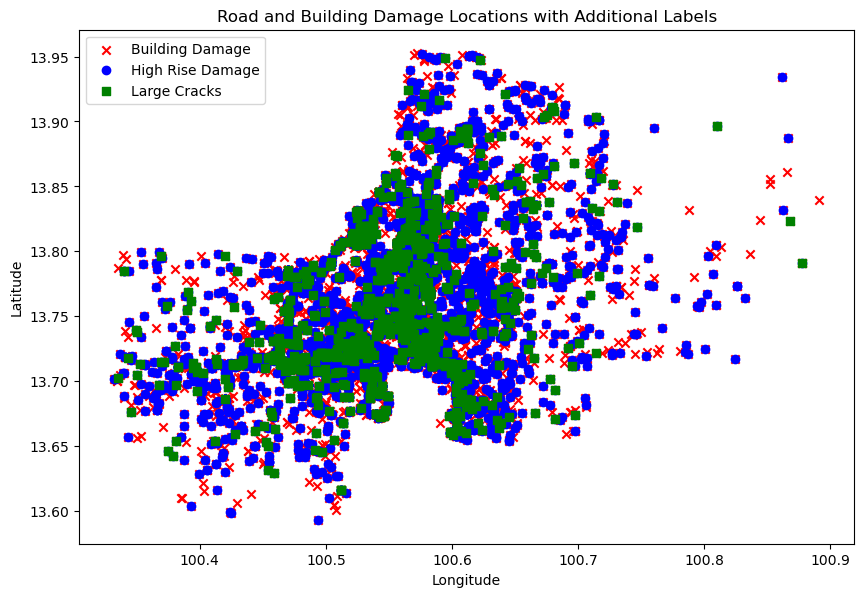

In [34]:
# Load the shapefiles
gdf_road = load_shapefile("road_damage.shp")
gdf_building = load_shapefile("building_damage.shp")

# Filter the rows where 'floor_label' is True and 'size_label' is True
high_rise_damage = gdf_building[gdf_building['floor_lb'] == True]
large_cracks = gdf_building[gdf_building['size_lb'] == True]

# Plot the GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))

# Plot building damage
gdf_building.plot(ax=ax, color='red', marker='x', label='Building Damage')

# Plot high rise damage (where 'floor_label' is True)
high_rise_damage.plot(ax=ax, color='blue', marker='o', label='High Rise Damage')

# Plot large cracks (where 'size_label' is True)
large_cracks.plot(ax=ax, color='green', marker='s', label='Large Cracks')

# Add labels, title, and legend
plt.title('Road and Building Damage Locations with Additional Labels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_6751/677516838.py:42: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


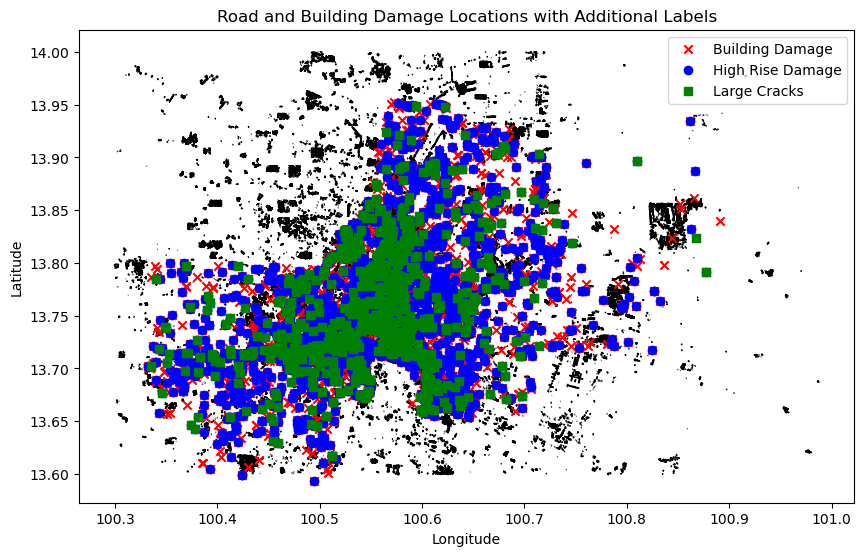

In [ ]:
# Filter the rows where 'floor_label' is True and 'size_label' is True
high_rise_damage = gdf_building[gdf_building['floor_lb'] == True]
large_cracks = gdf_building[gdf_building['size_lb'] == True]

# Load the Thailand shapefile from OpenStreetMap
gdf_thailand = load_csv("thailand-latest-free.shp/gis_osm_buildings_a_free_1.shp")

# Define the bounding box (latitude and longitude ranges)
lat_min, lat_max = 13.60, 14.0
lon_min, lon_max = 100.3, 101.0

# Filter Thailand boundary by bounding box
gdf_thailand = gdf_thailand.cx[lon_min:lon_max, lat_min:lat_max]

# Plot the GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Thailand boundary
gdf_thailand.plot(ax=ax, color='lightgray', edgecolor='black', label='Thailand Boundary')

# Plot building damage
gdf_building.plot(ax=ax, color='red', marker='x', label='Reported Building Damage')

# Plot building damage
gdf_road.plot(ax=ax, color='red', marker='x', label='Reported Road Damage')

# Add labels, title, and legend
plt.title('Road and Building Damage Locations with Additional Labels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_6751/623116654.py:61: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


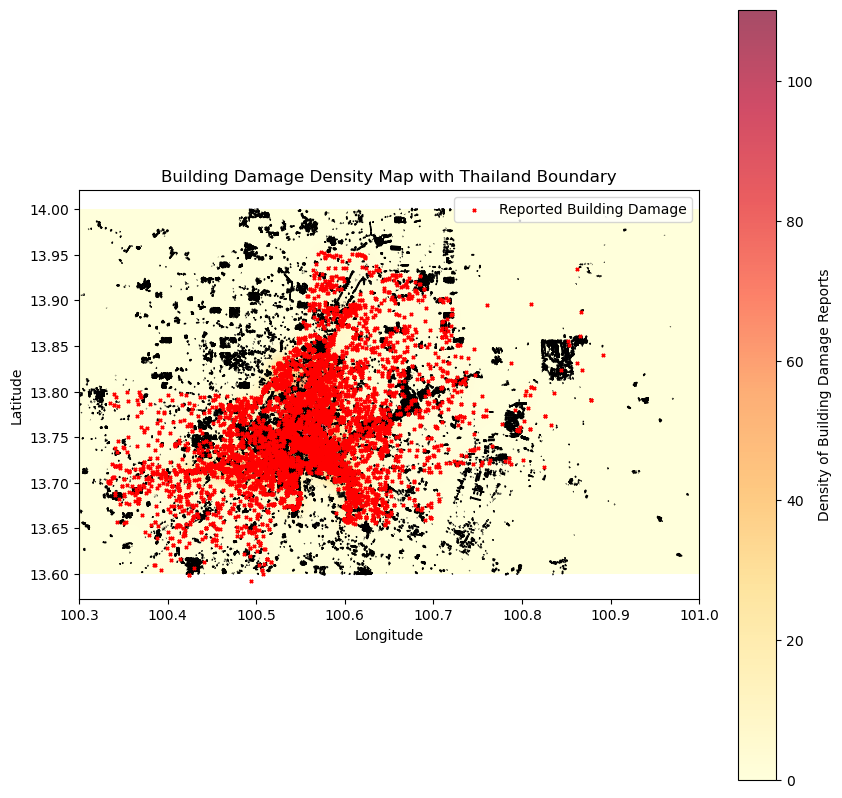

In [ ]:
# Define the bounding box (latitude and longitude ranges)
lat_min, lat_max = 13.60, 14.0
lon_min, lon_max = 100.3, 101.0

# Filter Thailand boundary by bounding box
gdf_thailand = gdf_thailand.cx[lon_min:lon_max, lat_min:lat_max]

# Filter the building damage data
high_rise_damage = gdf_building[gdf_building['floor_lb'] == True]
large_cracks = gdf_building[gdf_building['size_lb'] == True]

# Extract coordinates of building damage points for density estimation
coords = np.vstack([gdf_building.geometry.x, gdf_building.geometry.y]).T

# Perform Kernel Density Estimation (KDE)
kde = KernelDensity(kernel='gaussian', bandwidth=0.01)  # Adjust bandwidth for smoothing
kde.fit(coords)

# Create a grid of points over the region to evaluate the density on
x_grid = np.linspace(lon_min, lon_max, 300)
y_grid = np.linspace(lat_min, lat_max, 300)
X, Y = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate density on the grid
density = np.exp(kde.score_samples(grid_coords))

# Reshape the density back into the grid shape
density = density.reshape(X.shape)

# Plot the GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Thailand boundary
gdf_thailand.plot(ax=ax, color='lightgray', edgecolor='black', label='Thailand Boundary')

# Plot the building damage density map
cax = ax.imshow(density, origin='lower', extent=(lon_min, lon_max, lat_min, lat_max), cmap='YlOrRd', alpha=0.7)
fig.colorbar(cax, label='Density of Building Damage Reports')

# Plot building damage points (optional, can be commented out if not needed)
gdf_building.plot(ax=ax, color='red', marker='x', label='Reported Building Damage', markersize=5)

# Add labels, title, and legend
plt.title('Building Damage Density Map with Thailand Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_6751/428199955.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


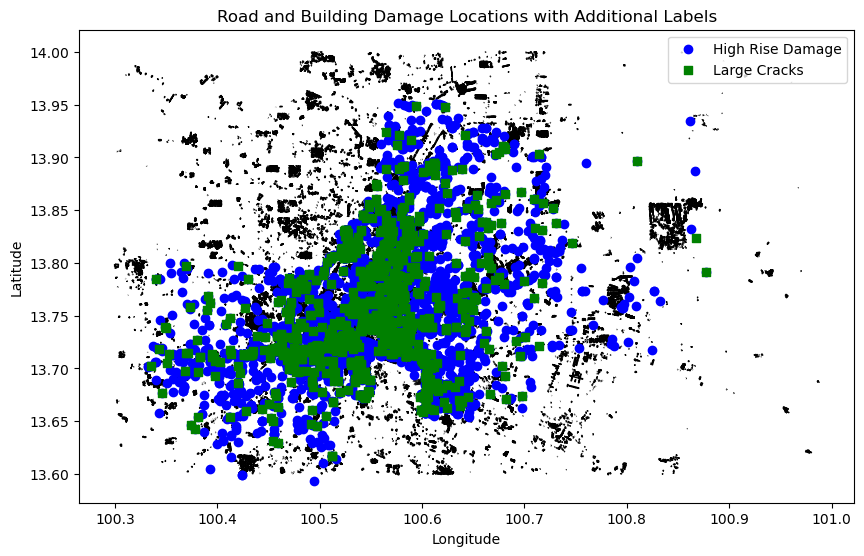

In [ ]:
# Define the bounding box (latitude and longitude ranges)
lat_min, lat_max = 13.60, 14.0
lon_min, lon_max = 100.3, 101.0

# Filter Thailand boundary by bounding box
gdf_thailand = gdf_thailand.cx[lon_min:lon_max, lat_min:lat_max]

# Plot the GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Thailand boundary
gdf_thailand.plot(ax=ax, color='lightgray', edgecolor='black', label='Thailand Boundary')


# Plot high rise damage (where 'floor_label' is True)
high_rise_damage.plot(ax=ax, color='blue', marker='o', label='High Rise Damage')

# Plot large cracks (where 'size_label' is True)
large_cracks.plot(ax=ax, color='green', marker='s', label='Large Cracks')

# Add labels, title, and legend
plt.title('Road and Building Damage Locations with Additional Labels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()